<a href="https://colab.research.google.com/github/samirapakravan/ScoreBasedDiffusionModel/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score Based Generative Modeling of MNIST Data with Stochastic Differential Equations

This is an implementation of the algorithm proposed in the following paper:



> *   Yang Song, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. "[Score-Based Generative Modeling through Stochastic Differential Equations.](https://arxiv.org/pdf/2011.13456.pdf)" Internation Conference on Learning Representations, 2021
*   More explanation can be found at https://yang-song.net/blog/2021/score/


##Note:
Here I implemented a U-Net architecure from scratch in such a way that is modular and flexible (arbitrarily changing the U-Net channels/embeddings and the code should work), the rest of the code is adapted from [Yang Song's tutorial](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing). 





In [1]:
#@title import necessary libraries.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import numpy as np
import functools

In [2]:
#@title choose a backend for training:

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

In [27]:
#@title U-Net model of the score-function.


class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]


class EncBlock(nn.Module):
    """A building block to compose the encoder stage of the U-Net. 
    
    Args:
      block_num: index of the current block in the encoder
      in_ch: size of the input channels
      out_ch: size of the output channels
      embed_dim: size of embeddings 
    """
    def __init__(self, block_num, in_ch, out_ch, embed_dim):
        super().__init__()
        if block_num==0:
          strd=1
          grp_sz=4
        else:
          strd=2
          grp_sz=32

        self.conv = nn.Conv2d(in_ch, out_ch, 3, stride=strd, bias=False)
        self.dense = Dense(embed_dim, out_ch)
        self.gnorm = nn.GroupNorm(grp_sz, num_channels=out_ch)
        self.swish_fn = lambda x: x * torch.sigmoid(x)
 
    def forward(self, x, embedding):
        h1 = self.conv(x)    
        h1 += self.dense(embedding)
        h1 = self.gnorm(h1)
        h1 = self.swish_fn(h1)
        return h1


class Encoder(nn.Module):
    """Encoder in U-net; this is a flexible implementation that user can change channels automatically
    
    Args:
      chs (tuple): channels that appear in the architecture
      embed_dim: dimensionality of the embedding
    """
    def __init__(self, chs=(1, 32, 64, 128, 256), embed_dim=256):
        super().__init__()
        self.enc_blocks = nn.ModuleList([EncBlock(i, chs[i], chs[i+1], embed_dim) for i in range(len(chs)-1)])

    def forward(self, x, embedding): 
        features = []
        for block in self.enc_blocks:
            x = block(x, embedding)
            features.append(x)
        return features



class DecBlock(nn.Module):
    """A building block to compose the decoder stage in the U-Net. 
    
    Args:
      block_num: index of the current block in the encoder
      in_ch: size of the input channels
      out_ch: size of the output channels
      embed_dim: size of embeddings 
    """
    def __init__(self, block_num, in_ch, out_ch, embed_dim):
        super().__init__()
        strd = 2
        grp_sz = 32
        if block_num==0:
          output_padding=0
          in_ch = in_ch
        else:
          output_padding=1
          in_ch = in_ch * 2

        self.tconv = nn.ConvTranspose2d(in_ch, out_ch, 3, stride=strd, bias=False, output_padding=output_padding)
        self.dense = Dense(embed_dim, out_ch)
        self.gnorm = nn.GroupNorm(grp_sz, num_channels=out_ch)
        self.swish_fn = lambda x: x * torch.sigmoid(x)
 
    def forward(self, x, embedding):
        h1 = self.tconv(x)    
        h1 += self.dense(embedding)
        h1 = self.gnorm(h1)
        h1 = self.swish_fn(h1)
        return h1


class Decoder(nn.Module):
    """Decoder in U-net; this is a flexible implementation that user can change channels automatically
    
    Args:
      chs (tuple): channels that appear in the architecture; should be reversed order of the Encoder
      embed_dim: dimensionality of the embedding
    """
    def __init__(self, chs=(256, 128, 64, 32, 1), embed_dim=256):
        super().__init__()
        self.len = len(chs)
        self.dec_blocks = nn.ModuleList([DecBlock(i, chs[i], chs[i+1], embed_dim) for i in range(len(chs)-2)])
        self.last_layer = nn.ConvTranspose2d(chs[-2] + chs[-2], 1, 3, stride=1)

    def forward(self, features, embedding): 
        x = features[0]
        x = self.dec_blocks[0](x, embedding)

        for i in range(1, self.len-2):
            x = torch.cat([x, features[i]], dim=1)
            x = self.dec_blocks[i](x, embedding)
        
        x = torch.cat([x, features[i+1]], dim=1)
        x = self.last_layer(x)

        return x


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[1, 32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    self.marginal_prob_std = marginal_prob_std
    self.swish_fn = lambda x: x * torch.sigmoid(x)

    # Gaussian random feature embedding layer for time
    self.embed_layer = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim), nn.Linear(embed_dim, embed_dim))

    # encoder and decoder
    self.encoder     = Encoder(chs=channels, embed_dim=embed_dim)
    self.decoder     = Decoder(chs=channels[::-1], embed_dim=embed_dim)
    

  def forward(self, x, t): 
    embedding = self.swish_fn(self.embed_layer(t)) 
    features  = self.encoder(x, embedding)
    h         = self.decoder(features[::-1], embedding)
    h         = h / self.marginal_prob_std(t)[:, None, None, None]     # Normalize output
    return h


In [7]:
#@title SDE model. Choose an appropriate denoising rate (sigma):

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model denoted by $s_\theta(x,t)$
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss


sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [28]:
#@title Data Parallel Training (double click to expand or collapse)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

## number of epochs for training
n_epochs =   50#@param {'type':'integer'}

## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}

## learning rate
lr=1e-4 #@param {'type':'number'}

## number of workers for data parallel training
num_workers = 4 #@param {'type':'integer'}

## load the MNIST dataset into the data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## choose an optimizer
optimizer = Adam(score_model.parameters(), lr=lr)

## training loop and logging
tqdm_epoch = tqdm.notebook.trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0

    for x, y in data_loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'checkpoint.pth')


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-7-892be6f2c1f4>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [29]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}

def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  return mean_x

<ipython-input-7-892be6f2c1f4>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-7-892be6f2c1f4>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


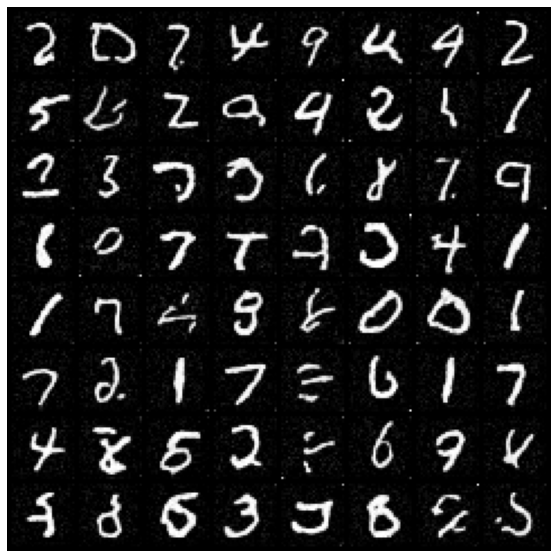

In [32]:
#@title Sampling at inference mode (double click to expand or collapse)
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda'           #@param ['cuda', 'cpu'] {'type':'string'}
sample_batch_size = 64    #@param {'type':'integer'}

ckpt = torch.load('checkpoint.pth', map_location=device)
score_model.load_state_dict(ckpt)

## Generate samples.
samples = Euler_Maruyama_sampler(score_model, 
                                marginal_prob_std_fn,
                                diffusion_coeff_fn, 
                                sample_batch_size, 
                                device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()